In [34]:
import skimage
import numpy as np 
import cv2
import pandas as pd 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
import os
import albumentations as A 
from collections import Counter
from sklearn.model_selection import train_test_split
import skimage.io
import torchvision
import random
import segmentation_models_pytorch as smp
from PIL import Image
import imageio
import glob


In [35]:
cfg = {'model_name': 'resnet101', # 'resnet18'     
      'encoder': 'timm-efficientnet-b0',
      'weights': 'imagenet', # 'instagram','imagenet'
      'loss': 'dice',  #  "crossentropy" or "dice"
      'final_size': 512, # 512 for retros and 800 for panos 
      'nb_classes': 1, 
      'epochs': 400, 
      'lr': 0.00001, 
      'gamma' : 0.95,
      'batch_size': 2
}


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL = cfg['model_name']
BATCH_SIZE = cfg['batch_size']
LR = cfg['lr']
EPOCHS = cfg['epochs']
FINAL_SIZE = cfg['final_size']
ENCODER = cfg['encoder']
ENCODER_WEIGHTS = cfg['weights']


In [36]:
root = '../../data'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')


In [37]:
def data_preparation(dataset):

    root = '../../data'
    exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

    if dataset == 'CHASE_DB1':
        input_data = os.path.join(root, 'CHASE_DB1/Images')
        images = sorted([os.path.join(input_data, fname) for fname in os.listdir(input_data) if fname.endswith(exts) and not fname.startswith(".")])

        target_data = os.path.join(root, 'CHASE_DB1/Masks')
        masks = sorted([os.path.join(target_data, fname) for fname in os.listdir(target_data) if fname.endswith('_2ndHO.png') and not fname.startswith(".")])

    elif  dataset == 'HRF':
        input_data = os.path.join(root, 'HRF/images')
        images = sorted([os.path.join(input_data, fname) for fname in os.listdir(input_data) if fname.endswith(exts) and not fname.startswith(".")])

        target_data = os.path.join(root, 'HRF/manual1')
        masks = sorted([os.path.join(target_data, fname) for fname in os.listdir(target_data) if fname.endswith(exts) and not fname.startswith(".")])

    elif dataset == 'DRIVE':

        input_data = os.path.join(root, 'DRIVE/training/images')
        images = sorted([os.path.join(input_data, fname) for fname in os.listdir(input_data) if fname.endswith(exts) and not fname.startswith(".")])


        target_data = os.path.join(root, 'DRIVE/training/1st_manual')
        masks = sorted([os.path.join(target_data, fname) for fname in os.listdir(target_data) if fname.endswith(exts) and not fname.startswith(".")])

    assert len(images) == len(masks)


    return images, masks
        



In [38]:
images_chase, masks_chase = data_preparation('CHASE_DB1')
images_hrf, masks_hrf = data_preparation('HRF')
images, masks = images_chase + images_hrf, masks_chase + masks_hrf


# shuffle for robust
combined = list(zip(images, masks))
random.shuffle(combined)
images, masks = zip(*combined)

print('Len Dataset : {}'.format(len(images)))

Len Dataset : 73


In [39]:
def train_augmentation(IMG_SIZE):

    return A.Compose([
                        # A.OneOf([A.MotionBlur(p=0.3), A.Blur(blur_limit=15, p=0.3), A.GaussNoise(p=0.2)], p=0.5),
                        # A.OneOf([A.CLAHE(p=0.3),A.RandomGamma(p=0.3)],p=1),
                        # A.Rotate(limit=30, p=1),
                        # A.RandomCrop(p=0.3, height=256, width=256),
                        # A.RandomBrightnessContrast(p=1),
                        A.Resize(IMG_SIZE,IMG_SIZE,interpolation=cv2.INTER_NEAREST)

                    ])
   

def test_augmentation(IMG_SIZE):
        
    return A.Compose([
                        A.Resize(IMG_SIZE,IMG_SIZE,interpolation=cv2.INTER_NEAREST),  
                        ])


In [40]:
class RetinaDataset(torch.utils.data.Dataset):

    def __init__(self, images, masks, augmentations):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # uint8 for data aug
        image = np.array(skimage.io.imread(image_path)).astype(np.uint8)
        mask = np.array(skimage.io.imread(mask_path)).astype(np.uint8)

        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

        image = np.array(image).astype(np.uint8)
        mask = np.array(mask).astype(np.uint8)

        image = image / 255
        image = torch.Tensor(image)
        image = torch.permute(image, (2,0,1))

        mask = np.where(mask>0, 255, 0)
        mask = mask / 255
        mask = torch.Tensor(mask)
        
        return image, mask, image_path



In [41]:
trainset = RetinaDataset(images[:58], masks[:58], train_augmentation(FINAL_SIZE))
testset = RetinaDataset(images[58:], masks[58:], test_augmentation(FINAL_SIZE))

In [42]:
dloader_train = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
dloader_test = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

# To get the same order for plot prediction
dloader_test_for_plot = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
def show_images(images, labels, preds, images_path):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(32, 16))
    
    for i, (image, mask, image_path) in enumerate(zip(images, labels, images_path)):
        orig_image = skimage.io.imread(image_path)
        width, height = orig_image.shape[:2]
        image = image.numpy().transpose((1, 2, 0))
        image = cv2.resize(image, dsize=(height,width), interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask.numpy(),2)
        mask = np.repeat(mask,3, axis=2)
        mask = cv2.resize(mask, dsize=(height,width), interpolation=cv2.INTER_NEAREST)

        axs[0, i].imshow(image)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        
        axs[1, i].imshow(mask)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

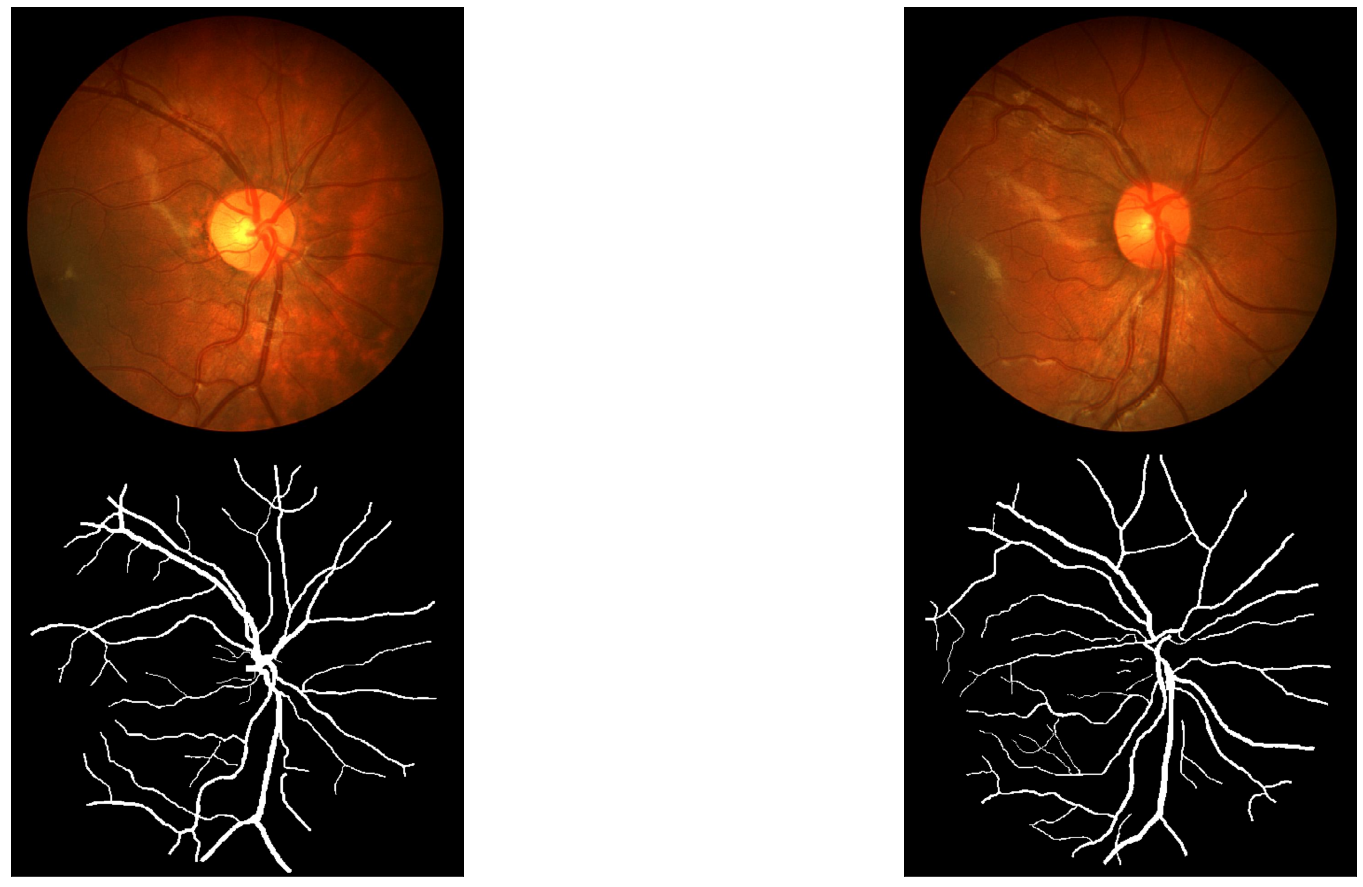

In [81]:
images, labels, image_path = next(iter(dloader_train))
show_images(images, labels, labels, image_path)

In [12]:
# CREATE MODEL

In [13]:
model = smp.UnetPlusPlus(encoder_name=ENCODER,
                        encoder_weights=ENCODER_WEIGHTS,
                        classes=1,
                        activation='sigmoid',
                        in_channels=3)

model.to(DEVICE)

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [14]:
# loss = smp.losses.DiceLoss(mode='binary', from_logits=False)
# loss.__name__ = "Dice_loss"

loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [15]:
def train_fn(data_loader, model, optimizer):
    
    model.train()
    total_loss = 0.0
    
    for images, masks, image_path in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = torch.unsqueeze(masks, 1)


        optimizer.zero_grad()
        out = model(images)
        l = loss(out, masks)
        l.backward()
        optimizer.step()

        total_loss += l.item()


    return total_loss / len(data_loader)


In [16]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad(): #pour ne pas tracer le gradient des variables 
    
    for images, masks, image_path in tqdm(data_loader):


        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = torch.unsqueeze(masks, 1)

        out = model(images)
        l = loss(out, masks)
        total_loss += l.item()


  return total_loss / len(data_loader)

In [18]:
def plot_pred(loader, epoch):

    for images, masks, image_path in tqdm(loader):
        
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = torch.unsqueeze(masks, 1)
        out = model(images)
        pred_mask = out[0,:,:,:]
        pred_mask = (pred_mask>0.5)*1.0
        res = pred_mask.detach().cpu().numpy()
        res = res.transpose((1,2,0))
        print(np.unique(res))
        print(res.shape)
        res = np.repeat(res,3,axis=2)
        plt.figure(figsize=(7,7))
        plt.imshow(res)
        plt.axis('off')
        plt.savefig('/workspace/' + str(epoch) +'.png')
        plt.show()
        break
  


In [ ]:
plot_pred(loader=dloader_test_for_plot,epoch=1)


In [ ]:
best_valid_loss = np.Inf
training_loss = []
test_loss = []

for i in range(EPOCHS):

  train_loss = train_fn(dloader_train, model, optimizer)
  valid_loss  = eval_fn(dloader_test,model)

  training_loss.append(train_loss)
  test_loss.append(test_loss)

  plot_pred(loader=dloader_test_for_plot,epoch=i)
 
  if valid_loss < best_valid_loss:
    torch.save(model,'best_model.pth')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch {i+1} Train loss {train_loss} Valid Loss {valid_loss} ")

INFERENCE 

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("* Load model ...")
model = torch.load('/workspace/simulations/simulation_1902_512_withoutscheduler/train/best_model.pth', map_location=DEVICE)
model
model.to(DEVICE)
model.eval()

* Load model ...


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [17]:
image, mask = testset[0]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (1,c,h,w)
pred_mask = (logits_mask>0.5)*1.0
res = pred_mask.squeeze(0).detach().cpu().numpy()
res = res.transpose((1,2,0))

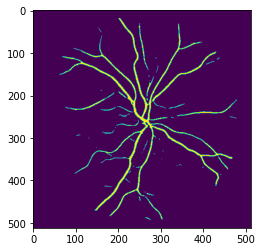

In [18]:
plt.imshow(res)

torch.Size([12, 512, 512])
(12, 1, 512, 512)
(512, 512, 12)


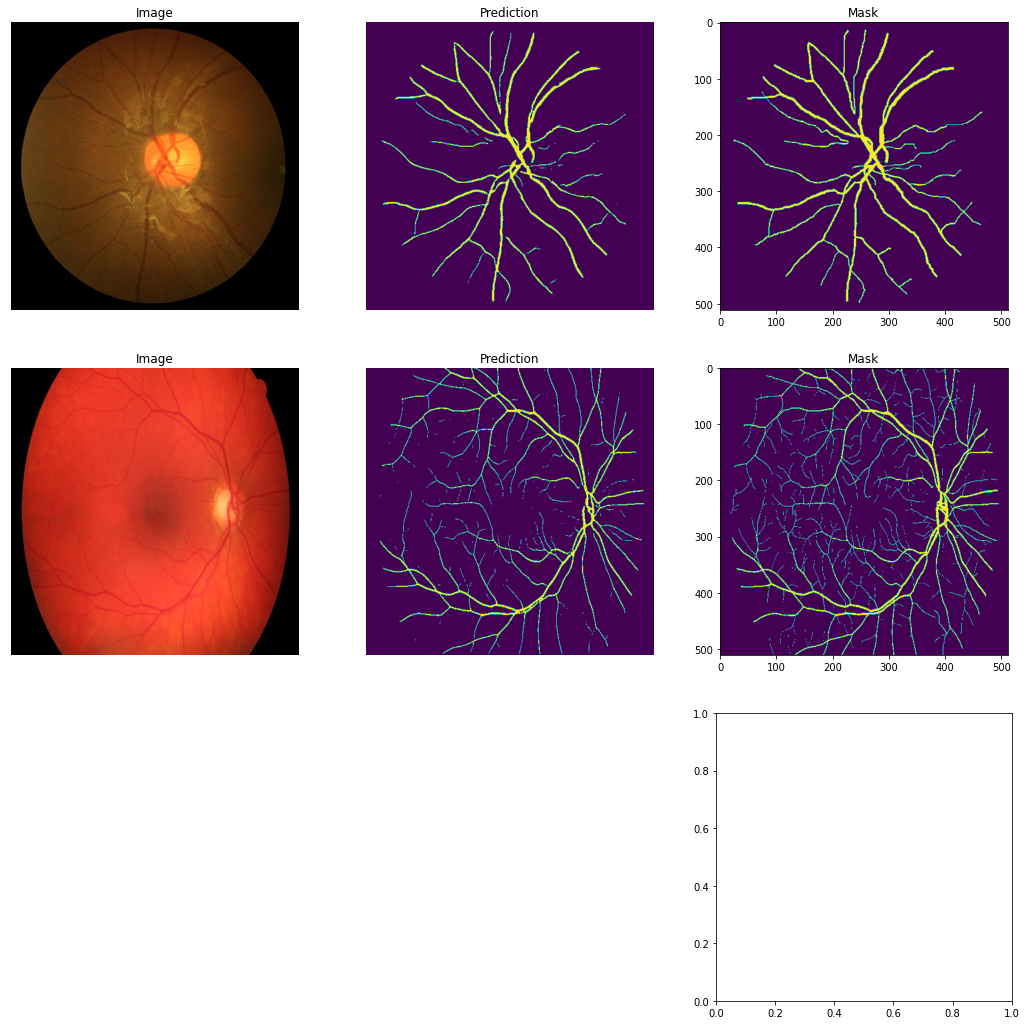

In [20]:
for image,mask in dloader_test:
    print(mask.shape)

    output = model(image.to(DEVICE)) 
    output = (output>0.5)*1.0
    output = output.squeeze(0).detach().cpu().numpy()
    print(output.shape)
    output = output[:,0,:,:]
    output = output.transpose((1,2,0))
    print(output.shape)
    

    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    img1 = np.transpose(np.array(image[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(output[:,:,0])

    mask1 = np.array(mask[0,:,:])

    img2 = np.transpose(np.array(image[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(output[:,:,1])
    mask2 = np.array(mask[1,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    # ax[2,0].set_title('Image')
    # ax[2,1].set_title('Prediction')
    # ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    # ax[0][2].axis("off")
    # ax[1][2].axis("off")
    # ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    break

In [113]:
def create_gif(folder):
    list_path_masks = sorted(glob.glob(folder+'/*.png'), key=lambda path : int(os.path.splitext(os.path.basename(path))[0]))
    images = [imageio.imread(path_mask) for path_mask in list_path_masks]
    imageio.mimsave("animation3.gif",images,duration=0.1)


In [ ]:
create_gif('/workspace/simulations/simulation_2302_withoutdataaug_smalllr/animations')

In [ ]:
# def plot_metrics(working_directory,experiment_name, training_loss, test_loss, config):
 

#     num_epochs = config['train']['epochs']
#     # save dir
#     save_dir = os.path.join(working_directory, experiment_name, 'train', 'figures')
#     os.makedirs(save_dir, exist_ok=True)

#     # get data to plot
#     plt.rcParams.update({'font.size': 25})

#     fig = plt.figure(figsize=(15, 10))
#     plt.plot(range(num_epochs), training_loss, color="red", label="Training loss")
#     plt.plot(range(num_epochs), test_loss, color="blue", label="Test loss")
#     plt.ylim(0), plt.legend(), plt.title("Loss")
#     plt.savefig(os.path.join(save_dir, 'loss.png'), bbox_inches='tight')